# Food Classification Project

In [ ]:
# load the dataset
# preprocess the dataset
# fit the dataset
# evaluate the dataset
# if performance is unsatisfactory preprocess it and fit and fit the model again
# and again till we get satisfactory performance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
import os,pathlib,random,zipfile,datetime
from sklearn import metrics

### Load the dataset

In [2]:
#Load the dataset
(train_data,test_data),metadata=tfds.load('food101',#name of the dataset to load
                                          split=['train','validation'],# split the dataset into train and validation
                                          shuffle_files=False,#randomly shuffle the files
                                          as_supervised=True,#get both images and labels
                                          with_info=True,# data comes with both images and labels
                                          download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteUIXWEX/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteUIXWEX/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Explore the Dataset

In [3]:
#get classnames
class_names=metadata.features['label'].names
class_names[:10]# get the first 10 classnames in the dataset

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [4]:
take_sample_image=train_data.take(1)# takes an image from train_data

In [5]:
#Exploring the data
for image, label in take_sample_image:
  print(f"""
  Image shape:{image.shape},
  Datatype of the Image:{image.dtype},
  Label(Tensor form):{label}
  Label(in str form):{class_names[label.numpy()]}
  """)


  Image shape:(512, 512, 3),
  Datatype of the Image:<dtype: 'uint8'>,
  Label(Tensor form):56
  Label(in str form):huevos_rancheros
  


In [6]:
print(f"Maximum and minimum in the Image is {tf.reduce_max(image)}, {tf.reduce_min(image)}")

Maximum and minimum in the Image is 255, 0


Text(0.5, 1.0, 'huevos_rancheros')

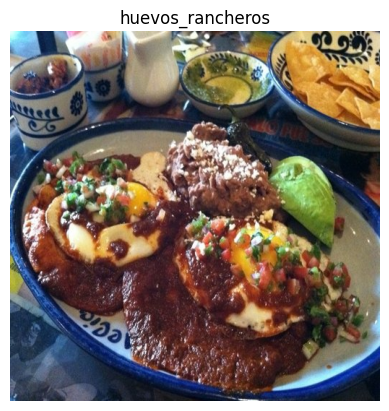

In [7]:
#Plot the image
plt.imshow(image)
plt.axis(False)
plt.title(class_names[label.numpy()])

# Preprocessing steps

In [8]:
def preprocess_image(image,label,image_shape=224):
  #resize the image
  image=tf.image.resize(image,[image_shape,image_shape])
  #change it's datatype from unit8 to float32 for speed
  #in computational purposes
  image=tf.cast(image,dtype=tf.float32)
  return image,label

In [9]:
preprocessed_image=preprocess_image(image,label)[0]

In [10]:
# Explore the preprocessed image
print(f""" After Preprocessing
  Image shape:{preprocessed_image.shape},
  Datatype:{preprocessed_image.dtype},\n
  Image:{preprocessed_image[:5]}
""")

 After Preprocessing
  Image shape:(224, 224, 3),
  Datatype:<dtype: 'float32'>,

  Image:[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]

 [[204.21428 253.42857 249.57143]
  [198.71428 254.64287 251.2449 ]
  [185.04591 251.73979 252.21428]
  ...
  [222.45403 207.47444 169.35715]
  [216.52551 205.01024 172.02556]
  [215.51529 207.87244 177.58672]]

 [[187.67857 252.64285 245.32143]
  [187.07143 254.5     250.92857]
  [175.32143 254.17857 253.10715]
  ...
  [225.3214  207.89287 164.5    ]
  [228.28568 213.35712 172.5    ]
  [225.53577 211.89294 173.71436]]

 [[165.65814 243.64795 238.21938]
  [169.5051  250.70409 248.0

(-0.5, 223.5, 223.5, -0.5)

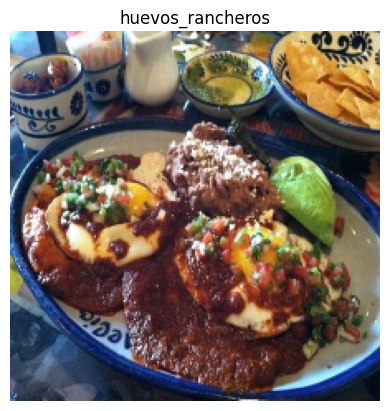

In [11]:
#plot the image
plt.imshow(preprocessed_image/255.0)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [12]:
#preprocess the entire train and test data
# pipeline the data
train_data=train_data.map(map_func=preprocess_image,#using the map function it preprocess the entire data
                          num_parallel_calls=tf.data.AUTOTUNE#makes the pipelining the data such that
                          #the processors are allocated for execution
                          )
#shuffles the dataset at randomly 1000 files, turning into batches and Pipelining
#using the prefetch if one batch is on execution then the next batch will be ready for execution
#Parallel execution happens here max utilization of the resources
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#for test_data
test_data=test_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
print(f"Train and Test data is \n {train_data},\n {test_data}")

Train and Test data is 
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [14]:
#creating our model callbacks
#1. Tensorboard callback
def create_tensorboard_callback(dirname,experiment_name):
  log_dir=dirname+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir)
  return tensorboard_callback

In [15]:
#2. Checkpoints
checkpoint_path='model_checkpoints/checkpoints.ckpt/'
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    monitor='val_loss',
                                                    save_freq='epoch',
                                                    save_best_only=True)

In [16]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-90aa9ba4-d003-50c8-23b8-7ae5b6fe7770)


In [17]:
# set the mixed precision
# we are doing these things for faster computational purposes
mixed_precision.set_global_policy(policy='mixed_float16')# float16 is combo of float16 and float32 datatypes

In [18]:
print(f" policy is set in {mixed_precision.global_policy()}")

 policy is set in <Policy "mixed_float16">


## Create Model
## Fine Tuning with ResNet50 model

In [19]:
# Data Augmentation layer
# By adding this layer our Model can learn through patterns in an efficient way
# model has more freedom to learn which helps in increasing accuracy
dataaugmentation_layer=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
],name="DataAugmentation_layer")

In [20]:
#we are fine tuning our with the base model ResNet50
# Fine tuning-1 :Feature extraction
image_shape=(224,224,3)
base_model=tf.keras.applications.ResNet50(include_top=False)#removing the top layer
base_model.trainable=False# we are not training the inner layers
inputs=tf.keras.layers.Input(shape=image_shape,name='Input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
x = tf.keras.layers.Rescaling(1./255)(inputs)
x=dataaugmentation_layer(x)
x=base_model(inputs,training=False)#setting the base model in inference mode only
#Pooling layer
x=tf.keras.layers.GlobalAveragePooling2D(name='Average_Pooling_layer')(x)
x=tf.keras.layers.Dense(units=len(class_names))(x)
# Here we are separating the activation because the we've to output in terms of float32
# But the computations will be in float16(mixed_float16)
# Separate activation of output layer so we can output float32 activations
outputs=tf.keras.layers.Activation(activation='softmax',dtype=tf.float32,name="Output_layer")(x)
fine_tuned_model_1=tf.keras.Model(inputs,outputs)

94765736/94765736 [==============================] - 0s 0us/step


In [21]:
#compile the model
loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
fine_tuned_model_1.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

In [22]:
# fit the model
history_model_1=fine_tuned_model_1.fit(train_data,epochs=3,steps_per_epoch=len(train_data),
                       validation_data=test_data,validation_steps=int(0.40*len(test_data)),
                       callbacks=[create_tensorboard_callback(dirname='Food_vision_Project',experiment_name='fine_tuned_model_1'),model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - 217s 85ms/step - loss: 2.5288 - accuracy: 0.4070 - val_loss: 1.9851 - val_accuracy: 0.5017
Epoch 2/3
2368/2368 [==============================] - 191s 79ms/step - loss: 1.9063 - accuracy: 0.5323 - val_loss: 1.9054 - val_accuracy: 0.5316
Epoch 3/3
2368/2368 [==============================] - 192s 79ms/step - loss: 1.6806 - accuracy: 0.5794 - val_loss: 1.8810 - val_accuracy: 0.5454


In [23]:
def plot_loss_accuracy_curves(model_history):
  loss=model_history.history['loss']
  accuracy=model_history.history['accuracy']
  val_loss=model_history.history['val_loss']
  val_accuracy=model_history.history['val_accuracy']
  epochs=range(len(model_history.history['loss']))
  #plot loss
  plt.plot(epochs,loss,label='Training loss',c='r')
  plt.plot(epochs,val_loss,label='Validation loss')
  plt.title("Loss")
  plt.xlabel('epochs')
  plt.legend()
  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='Training accuracy')
  plt.plot(epochs,val_accuracy,label='Validation accuracy',c='g')
  plt.xlabel('epochs')
  plt.title('Accuracy')
  plt.legend()

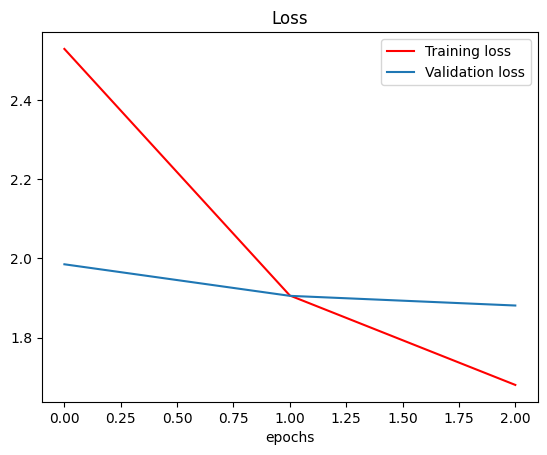

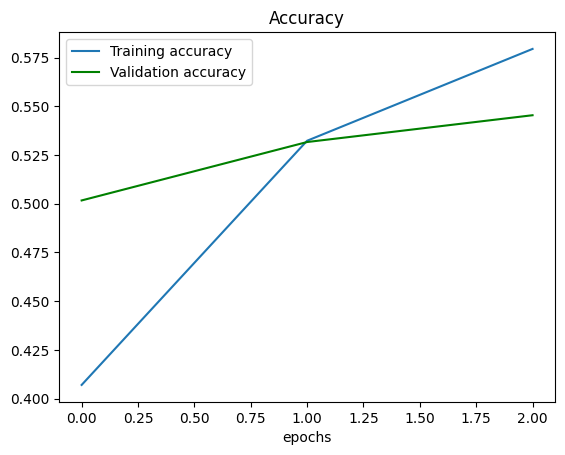

In [24]:
plot_loss_accuracy_curves(history_model_1)

In [25]:
model_1_results=fine_tuned_model_1.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.8876 - accuracy: 0.5415


In [27]:
print("Model 1 results after evaluation\n")
print(f"Loss: {model_1_results[0]}, Accuracy: {model_1_results[1]*100:.3f}%")

Model 1 results after evaluation

Loss: 1.8876296281814575, Accuracy: 54.154%


In [28]:
# Unfreezing the base model layers(Fine tuning)
# At first the inner layers of base model are not trainable..
# unfreezing the last 10 layers in the base_model
base_model.trainable=True
for layer in base_model.layers[:-10]:
  # set layer as trainable as false
  layer.trainable=False
#check whether the layers are trainable or not
for layer in base_model.layers[:-1]:
  print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [29]:
# How many layers are trainable ???
trainable_layers=0
for layer in base_model.layers:
  if layer.trainable==True:
    trainable_layers+=1
    print(layer.name)
print(f"Trainable layers in base_model {trainable_layers}")

conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Trainable layers in base_model 10


In [30]:
# Fine tuning - 2:
#we are fine tuning our with the base model ResNet50
# Fine tuning-1 :Feature extraction
image_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)#removing the top layer
base_model.trainable=False# we are not training the inner layers

inputs=tf.keras.layers.Input(shape=image_shape,name='Input_layer')
x=dataaugmentation_layer(inputs)
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
x = tf.keras.layers.Rescaling(1./255)(x)
x=base_model(inputs,training=False)#setting the base model in inference mode only
#Pooling layer
x=tf.keras.layers.GlobalAveragePooling2D(name='Average_Pooling_layer')(x)
x=tf.keras.layers.Dense(units=len(class_names))(x)
# Here we are separating the activation because the we've to output in terms of float32
# But the computations will be in float16(mixed_float16)
outputs=tf.keras.layers.Activation(activation='softmax',dtype=tf.float32,name="Output_layer")(x)
fine_tuned_model_2=tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [31]:
# Compile the model
fine_tuned_model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),# we decreased the learning rate by 10 times than previous one
                            metrics=['accuracy'])

In [32]:
# Fit the model
final_epochs=10 # to the last epoch
history_model_2=fine_tuned_model_2.fit(train_data,epochs=final_epochs,initial_epoch=history_model_1.epoch[-1],
                       validation_data=test_data,steps_per_epoch=len(train_data),
                       validation_steps=len(test_data),callbacks=[create_tensorboard_callback(dirname='Food_vision_Project',experiment_name='fine_tuned_model_2'),model_checkpoint])

Epoch 3/10
2368/2368 [==============================] - 266s 107ms/step - loss: 3.0218 - accuracy: 0.3954 - val_loss: 2.0510 - val_accuracy: 0.5777
Epoch 4/10
2368/2368 [==============================] - 232s 97ms/step - loss: 1.9317 - accuracy: 0.5743 - val_loss: 1.5881 - val_accuracy: 0.6362
Epoch 5/10
2368/2368 [==============================] - 258s 108ms/step - loss: 1.6431 - accuracy: 0.6135 - val_loss: 1.4054 - val_accuracy: 0.6606
Epoch 6/10
2368/2368 [==============================] - 226s 94ms/step - loss: 1.4995 - accuracy: 0.6364 - val_loss: 1.3053 - val_accuracy: 0.6760
Epoch 7/10
2368/2368 [==============================] - 230s 96ms/step - loss: 1.4078 - accuracy: 0.6526 - val_loss: 1.2409 - val_accuracy: 0.6860
Epoch 8/10
2368/2368 [==============================] - 224s 93ms/step - loss: 1.3411 - accuracy: 0.6652 - val_loss: 1.1946 - val_accuracy: 0.6936
Epoch 9/10
2368/2368 [==============================] - 221s 92ms/step - loss: 1.2888 - accuracy: 0.6761 - val_loss:

In [33]:
model_2_results=fine_tuned_model_2.evaluate(test_data)

790/790 [==============================] - 53s 66ms/step - loss: 1.1320 - accuracy: 0.7073


In [34]:
print(f"Model 2(Fine Tuning):\n Loss: {model_2_results[0]}\n Accuracy: {model_2_results[1]*100:.3f}%")

Model 2(Fine Tuning):
 Loss: 1.1320044994354248
 Accuracy: 70.729%


In [35]:
def compare_historys(original_history, new_history, initial_epochs=history_model_1.epoch[-1]):
    """
    Compares two TensorFlow model History objects.
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning- 2') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning- 2') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

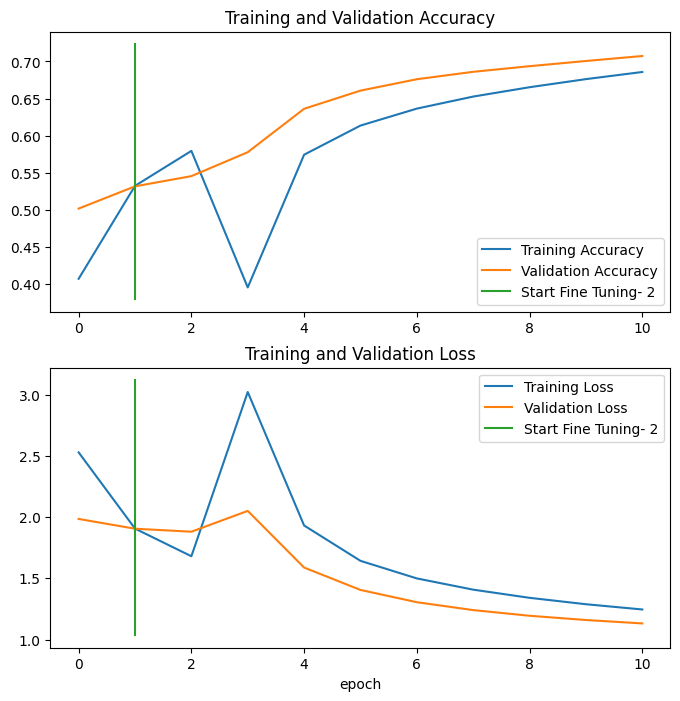

In [36]:
compare_historys(history_model_1,history_model_2)

## Save the model

In [37]:
fine_tuned_model_1.save('drive/MyDrive/Colab Notebooks/learning/food_vision_model_1')

In [38]:
fine_tuned_model_2.save('drive/MyDrive/Colab Notebooks/learning/food_vision_model_2')

# Results and Analysis

In [39]:
y_probs=fine_tuned_model_2.predict(test_data,verbose=1)

790/790 [==============================] - 54s 66ms/step


In [40]:
pred_classes=y_probs.argmax(axis=1)

In [41]:
y_labels=[]
for _,label in test_data:
  y_labels.extend(label.numpy())

In [42]:
labels_array=np.array(y_labels)

In [44]:
labels_array[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [43]:
pred_classes[:20]

array([100,  81,  91,  53,  97,  97,  10,  31,   3,  94,  19,  32,  32,
        10,   8,   8,  44,  60,  29,  80])

In [78]:
pred_classes[0].dtype,y_labels[0].dtype

(dtype('int64'), dtype('int64'))

In [45]:
# accuracy
accuracy_score=metrics.accuracy_score(y_true=labels_array,y_pred=pred_classes)

In [80]:
print(f"Accuracy Score is {accuracy_score*100:.3f}%")

Accuracy Score is 70.729%


In [48]:
print("Classification report")
print(metrics.classification_report(y_true=labels_array,y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.54      0.38      0.44       250
           1       0.76      0.70      0.73       250
           2       0.74      0.76      0.75       250
           3       0.71      0.70      0.71       250
           4       0.57      0.57      0.57       250
           5       0.58      0.61      0.60       250
           6       0.80      0.83      0.82       250
           7       0.81      0.86      0.83       250
           8       0.45      0.50      0.47       250
           9       0.67      0.60      0.63       250
          10       0.59      0.56      0.57       250
          11       0.69      0.78      0.73       250
          12       0.77      0.74      0.76       250
          13       0.66      0.66      0.66       250
          14       0.71      0.68      0.70       250
          15       0.52      0.46      0.49       250
          16       0.55      0.54      0.54       250
          17       0.68    

In [51]:
classification_report_dict=metrics.classification_report(labels_array,pred_classes,output_dict=True)

In [52]:
classification_report_dict

{'0': {'precision': 0.5371428571428571,
  'recall': 0.376,
  'f1-score': 0.44235294117647056,
  'support': 250},
 '1': {'precision': 0.7553648068669528,
  'recall': 0.704,
  'f1-score': 0.7287784679089028,
  'support': 250},
 '2': {'precision': 0.7374517374517374,
  'recall': 0.764,
  'f1-score': 0.75049115913556,
  'support': 250},
 '3': {'precision': 0.7125506072874493,
  'recall': 0.704,
  'f1-score': 0.7082494969818913,
  'support': 250},
 '4': {'precision': 0.5652173913043478,
  'recall': 0.572,
  'f1-score': 0.5685884691848906,
  'support': 250},
 '5': {'precision': 0.5846153846153846,
  'recall': 0.608,
  'f1-score': 0.596078431372549,
  'support': 250},
 '6': {'precision': 0.8,
  'recall': 0.832,
  'f1-score': 0.8156862745098038,
  'support': 250},
 '7': {'precision': 0.8136882129277566,
  'recall': 0.856,
  'f1-score': 0.8343079922027291,
  'support': 250},
 '8': {'precision': 0.44765342960288806,
  'recall': 0.496,
  'f1-score': 0.4705882352941177,
  'support': 250},
 '9': {'

In [53]:
class_f1_scores={} # classname:f1-score
for key,value in classification_report_dict.items():
  if key=='accuracy':
    break
  else:
    class_f1_scores[class_names[int(key)]]=value['f1-score']
  class_f1_scores

In [54]:
class_f1_scores

{'apple_pie': 0.44235294117647056,
 'baby_back_ribs': 0.7287784679089028,
 'baklava': 0.75049115913556,
 'beef_carpaccio': 0.7082494969818913,
 'beef_tartare': 0.5685884691848906,
 'beet_salad': 0.596078431372549,
 'beignets': 0.8156862745098038,
 'bibimbap': 0.8343079922027291,
 'bread_pudding': 0.4705882352941177,
 'breakfast_burrito': 0.634453781512605,
 'bruschetta': 0.5749486652977414,
 'caesar_salad': 0.7330827067669173,
 'cannoli': 0.7551020408163266,
 'caprese_salad': 0.66,
 'carrot_cake': 0.6952965235173824,
 'ceviche': 0.4883227176220807,
 'cheesecake': 0.54251012145749,
 'cheese_plate': 0.6877470355731224,
 'chicken_curry': 0.6085192697768763,
 'chicken_quesadilla': 0.7335907335907337,
 'chicken_wings': 0.7838383838383839,
 'chocolate_cake': 0.6451612903225806,
 'chocolate_mousse': 0.5213849287169043,
 'churros': 0.8166666666666667,
 'clam_chowder': 0.7946768060836503,
 'club_sandwich': 0.760233918128655,
 'crab_cakes': 0.5562130177514794,
 'creme_brulee': 0.8221343873517787

In [56]:
f1_scores=pd.DataFrame({"class_names":list(class_f1_scores.keys()),# into a dataframe classname and it's f1-score
                        "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [57]:
f1_scores.head()

,class_names,f1-score
33,edamame,0.983936
63,macarons,0.928287
91,spaghetti_carbonara,0.892788
54,hot_and_sour_soup,0.890625
75,pho,0.886228


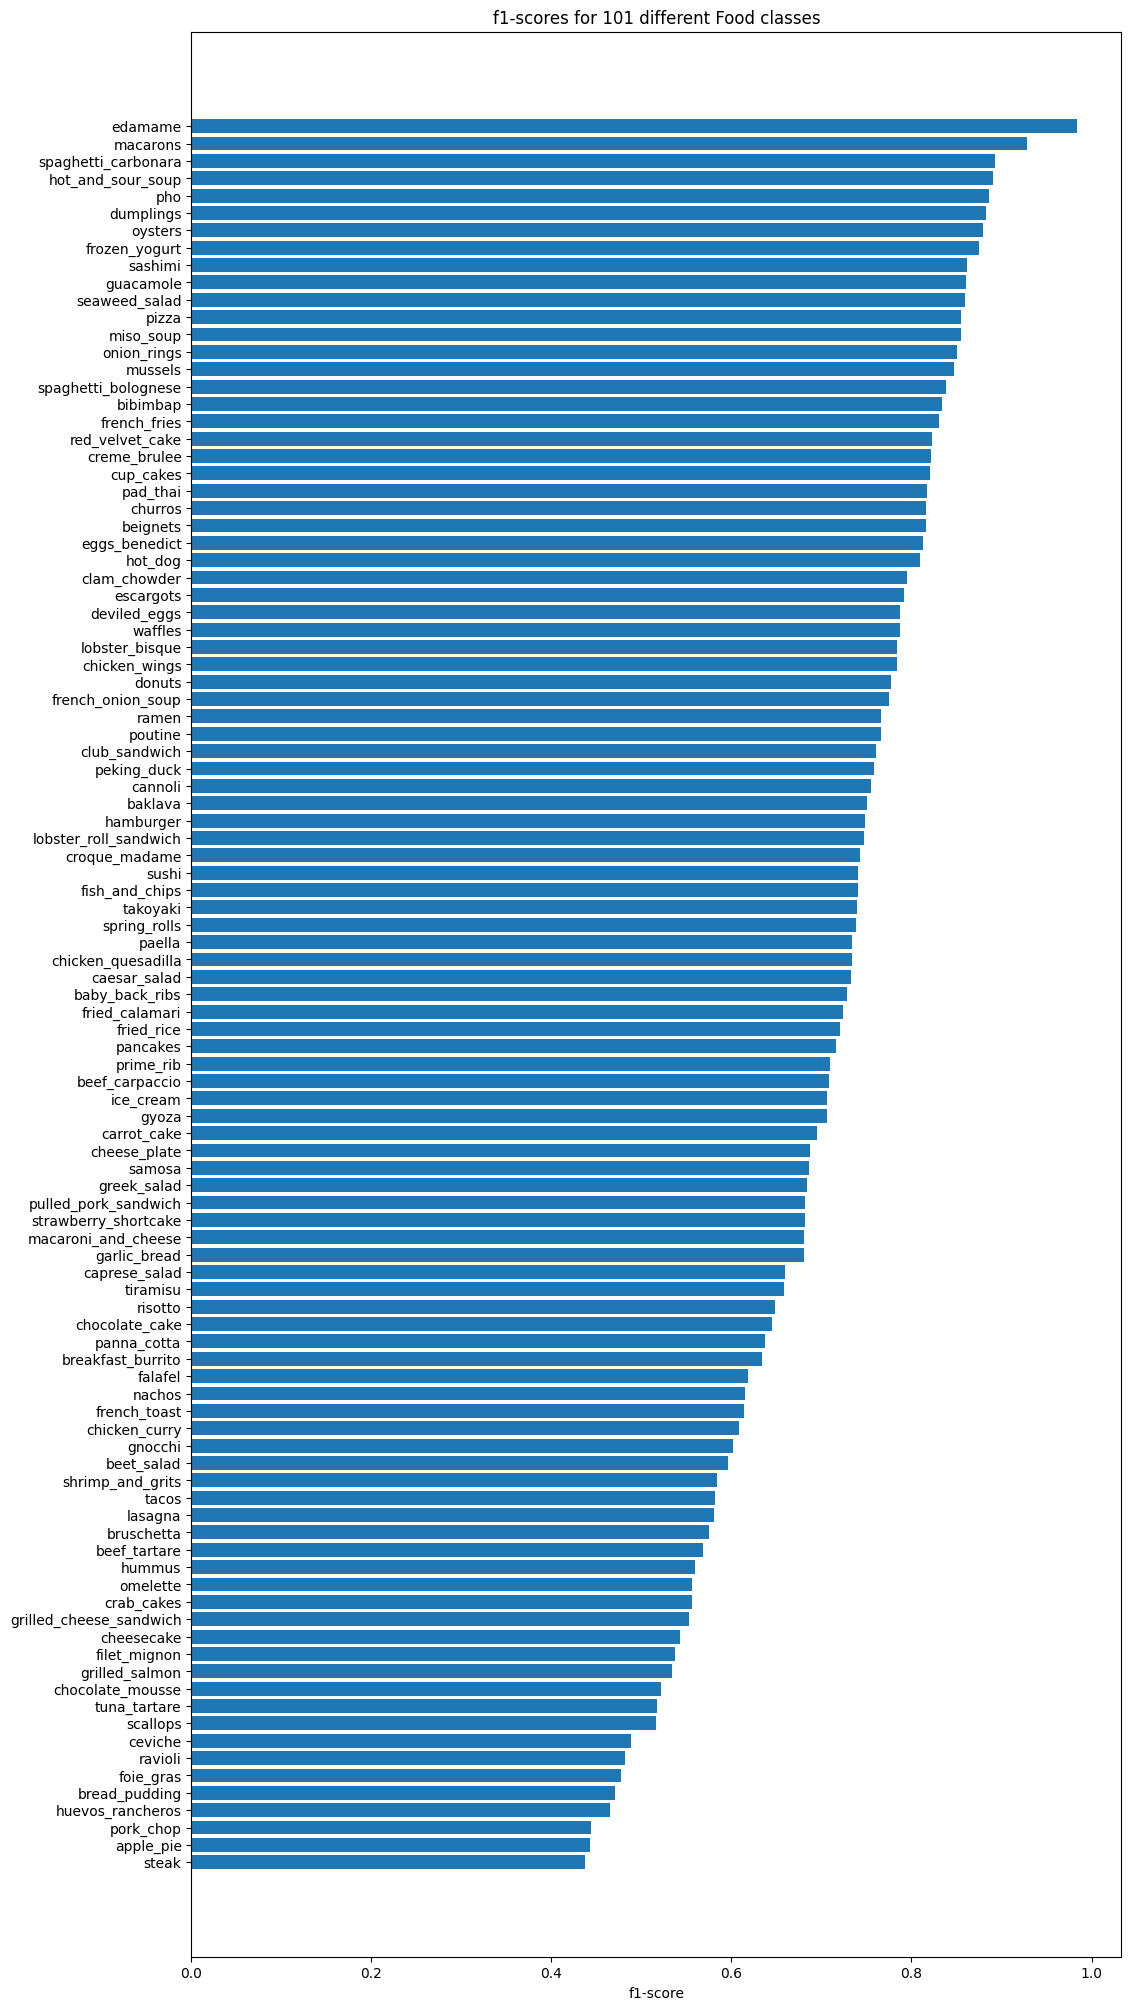

In [59]:
fig,ax=plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)),f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel("f1-score")
ax.set_title("f1-scores for 101 different Food classes")
ax.invert_yaxis()

In [83]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-15 09:09:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-15 09:09:15 (76.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [84]:
from helper_functions import make_confusion_matrix

In [86]:
make_confusion_matrix(y_true=labels_array,y_pred=pred_classes,classes=class_names,figsize=(100,100),text_size=20)

Output hidden; open in https://colab.research.google.com to view.

# Predictions

In [61]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-11-15 08:29:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.207, 209.85.200.207, 173.194.206.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  72.4MB/s    in 32s     

2023-11-15 08:30:16 (49.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [62]:
zip_ref=zipfile.ZipFile('101_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [63]:
test_dir='101_food_classes_10_percent/test'

In [64]:
def load_and_prep_image(filename,image_shape=224,scale=True):
  image=tf.io.read_file(filename)
  image=tf.io.decode_image(image,channels=3)
  image=tf.image.resize(image,size=[image_shape,image_shape])
  if scale:
    return image/255.0
  return image

1/1 [==============================] - 0s 99ms/step


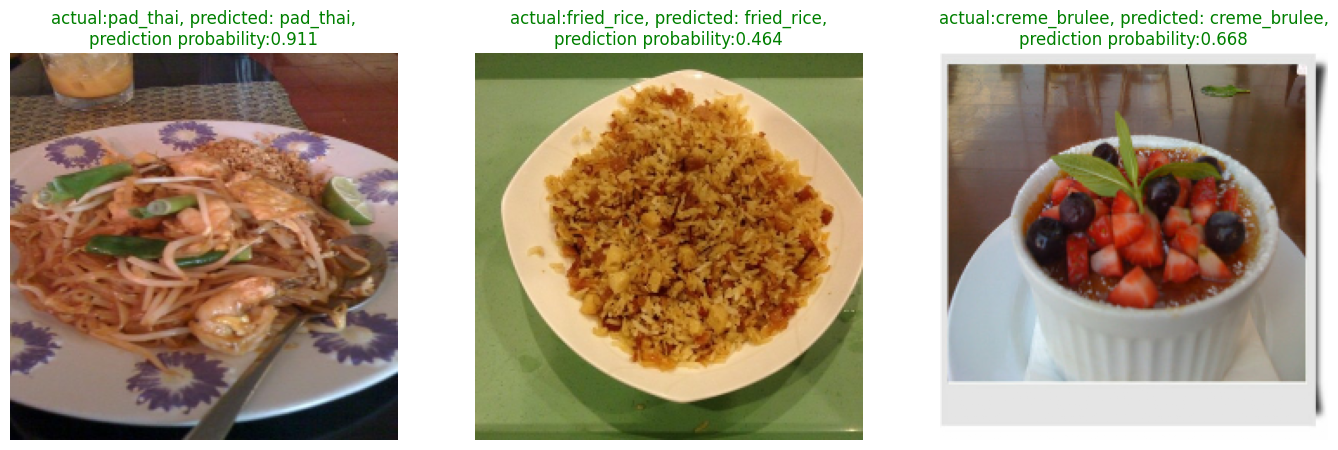

In [82]:
plt.figure(figsize=(17,10))
for i in range(3):
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+'/'+class_name))
  filepath=test_dir+'/'+class_name+'/'+filename
  # print(filepath)
  image=load_and_prep_image(filepath,scale=False)
  pred_prob=fine_tuned_model_2.predict(tf.expand_dims(image,axis=0))
  pred_class=class_names[pred_prob.argmax()]
  # print(pred_prob.max())
  # print(pred_class)
  plt.subplot(1,3,i+1)
  plt.imshow(image/255.0)
  if class_name==pred_class:
    title_color='g'
  else:
    title_color='r'
  plt.title(f"actual:{class_name}, predicted: {pred_class},\nprediction probability:{pred_prob.max():.3f}",c=title_color)
  plt.axis("off")